In [1]:
import fenics as fn
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import mu_0, epsilon_0
import os

In [2]:
r = 1.5
R = 9
b = 1

In [3]:
b = np.arange(0, 6)
charimp = np.zeros(len(b))
b

array([0, 1, 2, 3, 4, 5])

# Numerical Solution
The following code will perform a parameter sweep of the conenticity, $b$.

b = 0
Z_0 = 62.02


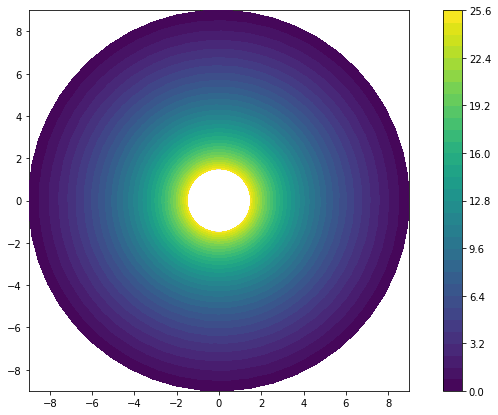

b = 1
Z_0 = 61.58


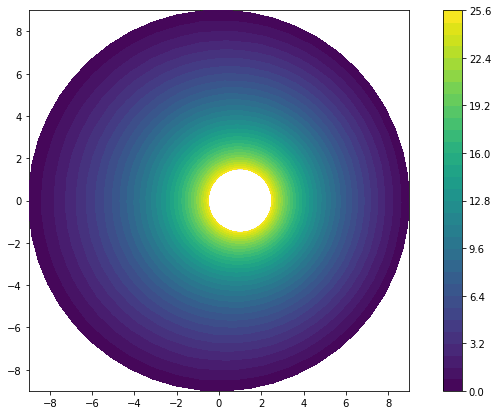

b = 2
Z_0 = 60.21


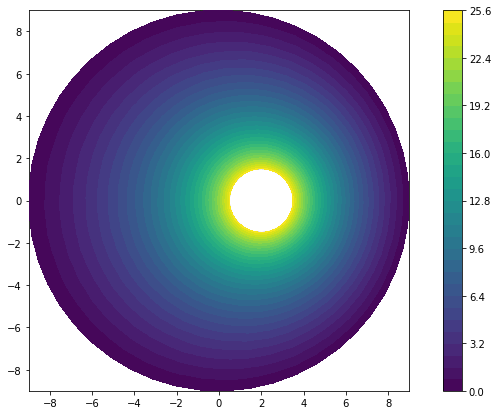

b = 3
Z_0 = 57.79


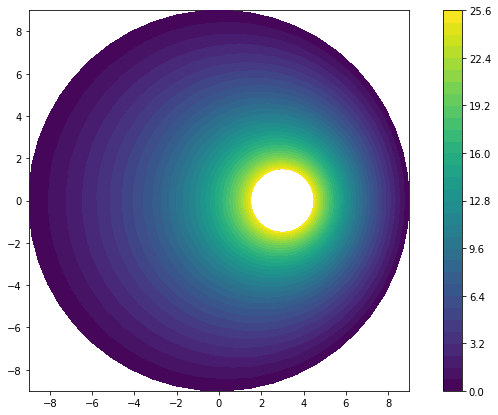

b = 4
Z_0 = 54.07


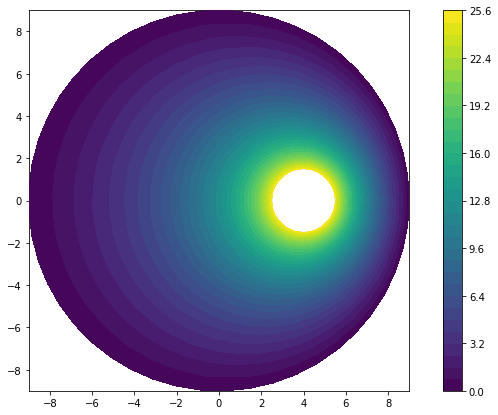

b = 5
Z_0 = 48.53


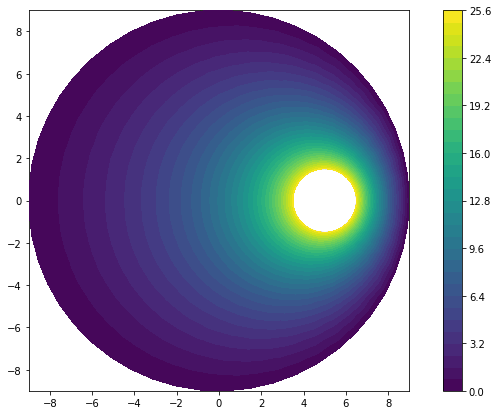

In [4]:
for n,bb in enumerate(b):
    # Mesh the geometry and convert it
    os.system("rm geo.msh")
    os.system("rm *.xml")
    os.system("gmsh -2 geo.geo -format msh2 -setnumber b {}".format(bb))
    os.system("dolfin-convert geo.msh geo.xml")
    
    mesh = fn.Mesh('geo.xml')
    subdomains = fn.MeshFunction("size_t", mesh, 'geo_physical_region.xml')
    boundaries = fn.MeshFunction('size_t', mesh, 'geo_facet_region.xml')
    
    # Define the function space
    P1 = fn.FiniteElement("Lagrange", mesh.ufl_cell(), 1)
    V = fn.FunctionSpace(mesh, 'CG', 2)
    
    # Define measures for performing integrals
    dx = fn.Measure('dx', domain=mesh, subdomain_data=subdomains)
    ds = fn.Measure('ds', domain=mesh, subdomain_data=boundaries)
    
    # Define the boundary conditions
    voltage = 25
    inner_boundary = fn.DirichletBC(V, fn.Constant(voltage), boundaries, 2)
    outer_boundary = fn.DirichletBC(V, fn.Constant(0), boundaries, 3)
    bcs =[inner_boundary, outer_boundary]
    
    # Solve the Poisson Equation
    u = fn.TrialFunction(V)
    v = fn.TestFunction(V)
    a = fn.dot(fn.grad(u), fn.grad(v)) * dx
    L = fn.Constant('0') * v * dx
    u = fn.Function(V)
    fn.solve(a == L, u, bcs)
    
    # Define some constants
    epsilon_r = 3    
    
    E = -fn.grad(u)
    # Define some unit vectors which will be used later
    xhat = fn.Expression(('1.0', '0.0'), V, degree=1)
    yhat = fn.Expression(('0.0', '1.0'), V, degree=1)
    
    # calculate the H field
    z_tem = fn.Constant(np.sqrt(mu_0/epsilon_0/epsilon_r))
    e_x = fn.dot(E, xhat)
    e_y = fn.dot(E, yhat)
    h = 1/z_tem * fn.as_vector([-e_y, +e_x])
    
    
    # Calculate the peak Poynting vector
    S = (fn.dot(E, xhat)*fn.dot(h, yhat) -
               fn.dot(E,yhat)*fn.dot(h, xhat))
    
    power = fn.assemble(S * dx(1))
    charimp[n] = voltage**2/power
    
    print("b = {}".format(bb))
    print("Z_0 = {:.2f}".format(voltage**2 / power))
    
    plt.figure(figsize=(12,7))
    fn.plot(mesh, linewidth=0.5)
    p = fn.plot(u, zorder=3)
    plt.colorbar(p)
    plt.show()

# Analytical

In [5]:
Z0=60/np.sqrt(epsilon_r)*np.log((np.sqrt(((r-b)**2-R**2)*((r+b)**2-R**2))+r**2 + R**2 - b**2)/(2*R*r))
print(Z0)

[62.06836871 61.62550215 60.25972173 57.84769211 54.13522124 48.61559842]


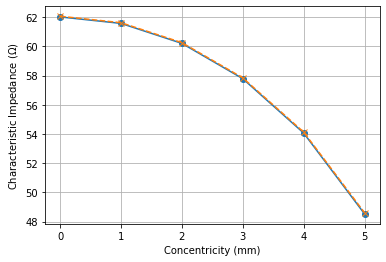

In [8]:
plt.plot(b, charimp, '-o')
plt.plot(b, Z0, '--x')
plt.xlabel("Concentricity (mm)")
plt.ylabel(r"Characteristic Impedance ($\Omega$)")
plt.grid()